# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import soundfile
import os, glob, pickle
import resampy
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Feature Extraction (MFCC, Chroma, Mel) from a SoundFile

- MFCCs: Capture the spectral characteristics of a sound signal, often used in speech and speaker recognition.
- Chroma: Describe the harmonic content of an audio signal, commonly used in speech analysis tasks.
- Mel Spectrogram: Represents the frequency content of an audio signal in a way that aligns with human auditory perception. It is often used for visualization and feature extraction in speech and audio processing tasks.
- The Short-Time Fourier Transform (STFT) is a technique used in signal processing to analyze how the frequency content of a signal evolves over time.
- axis=0: Specifies that the operation should be performed along the vertical axis, meaning the operation is applied to each column separately, treating the columns as independent entities.

In [2]:
def extract_feature(file_name, mfcc, chroma, mel):
    # Load audio file using librosa
    # The loaded audio signal is stored in the variable X, and the sample rate of the audio file is stored in sample_rate.
    X, sample_rate = librosa.load(os.path.join(file_name), res_type="scipy")
    # If chroma is requested, calculate the short-time Fourier transform (stft)
    if chroma:
        stft = np.abs(librosa.stft(X)) # The absolute values of the STFT are taken using np.abs and stored in the variable stft
     # Initialize an empty array to store the extracted features
    result = np.array([])
    # If MFCC is requested, calculate and append to the result array
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate,  n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    # If chroma is requested, calculate and append to the result array
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma))
    # If mel is requested, calculate and append to the result array
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel))
    return result

In [3]:
emotions = {
    "01":"Neutral",
    "02":"Calm",
    "03":"Happy",
    "04":"Sad",
    "05":"Angry",
    "06":"Fearful",
    "07":"Disgust",
    "08":"Surprised",
}
# Emotion to be observed
observed_emotions = ["Calm", "Happy", "Fearful"]

# Load Data and Extract Feature for each soundfile

In [6]:
# @title Load the data & Extract features for each Soundfile
def load_data(path, test_size = 0.3):
    # Initialize empty lists for storing features and labels
    x,y = [],[]
    #Iterate over each file in the specified path
    for file in glob.glob(path):
        # Get the base name of the current file
        file_name = os.path.basename(file)
        # Extract the emotion label from the file name
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
         # Extract features from the current audio file
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
     # Split the data into training and testing sets and return the four resulting arrays
    return train_test_split(np.array(x), np.array(y), test_size=test_size, random_state=3)

In [9]:
files_path = "C:\\Users\\Lenovo\\Desktop\\ML Project\\RAVDESS2\\Actor_*\\*.wav"
X_train, X_test, Y_train, Y_test = load_data(files_path, test_size = 0.35)

In [10]:
# Save features and emotions to a CSV file
data = pd.DataFrame(X_train, columns=[f'feature_{i+1}' for i in range(X_train.shape[1])])
data['emotion'] = Y_train

# Save to CSV
csv_filename = "extracted_features_and_emotions.csv"
data.to_csv(csv_filename, index=False)

print(f"Data saved to {csv_filename}")

Data saved to extracted_features_and_emotions.csv


# Data Visualization

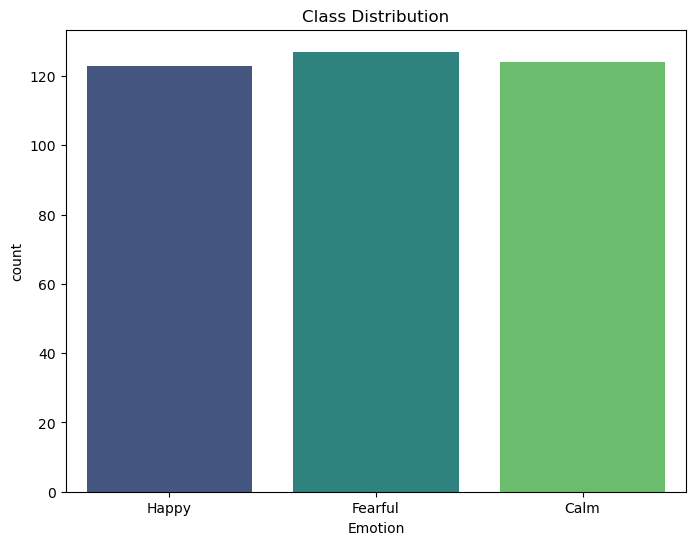

In [11]:
df = pd.DataFrame(data={'Emotion': Y_train})

#Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Emotion', data=df, palette='viridis')
plt.title('Class Distribution')
plt.show()

# Multi-Layer Perceptron (MLP)

In [30]:
model = MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,), learning_rate="adaptive", max_iter=600)

In [31]:
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=Y_test, y_pred=Y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 85.15%


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


# Classification Report

In [32]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

        Calm       0.89      0.91      0.90        68
     Fearful       0.86      0.77      0.81        65
       Happy       0.81      0.87      0.84        69

    accuracy                           0.85       202
   macro avg       0.85      0.85      0.85       202
weighted avg       0.85      0.85      0.85       202



# Confusion Matrix

In [26]:
matrix = confusion_matrix(Y_test, Y_pred)
print(matrix)

[[38  6  4]
 [ 2 31  8]
 [ 3 15 24]]


# Support Vector Machine (SVC)

In [47]:
svm_model = SVC(C=1.0, kernel='linear', random_state=9)

In [43]:
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy Score: {accuracy*100:.2f}%")

Accuracy Score: 75.74%


# Predictive Model

In [46]:
# Example for input validation
def predict_emotion(file_path):
    feature = extract_feature(file_path, mfcc=True, chroma=True, mel=True)
    feature = feature.reshape(1, -1)  # Reshape to match the input format expected by the model
    emotion = model.predict(feature)[0]
    return emotion

# Example usage for input validation
new_file_path = "C:/Users/Lenovo/Desktop/ML Project/audio-dataset/A4/03-01-02-02-01-01-04.wav"
predicted_emotion = predict_emotion(new_file_path)
print("Predicted Emotion:", predicted_emotion)

Predicted Emotion: Calm
